# Concept of a Double Tilted Rowland Spectrograph

In [1]:
from copy import deepcopy
import warnings
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from x3d import x3d

import marxs
from marxs.visualization.x3d import plot_object, plot_rays
from marxs import optics, source, simulator
from marxs.design import rowland
import marxs.analysis

from marxs.optics.base import OpticalElement
from marxs.simulator import ParallelCalculated, Parallel
from marxs.missions.athena.spo import ScatterPerChannel, spomounting

import transforms3d

import matplotlib.pyplot as plt

x3d.py package 4.0.64.2 loaded, have fun with X3D Graphics!


In [2]:
class Camera(ParallelCalculated, OpticalElement):
    '''CCD detectors in camera layout

    8 CCDs in each strip, with gaps between them in 3-2-3 groups
    to match the shadows from the filter support.
    One strip is offset by a few mm so that the chip gaps fall
    into slightly different positions.
    
    Parameters
    ----------
    rowland_detector : RowlandTorus
        RowlandTorus object
    det_kwargs : dict
        Keyword arguments for the detector elements
    n_det : int
        Number of detectors per strip
    phi_det_start : float
        Angle of the first detector in rad
    d : float
        Distance between the optical axis of the Rowland circle for detectors and mirror/grating
    offset : list of float
        offset of one strip vs the other to avoid matching chip gaps in mm
    '''
    ccd_gap = 1
    
    def __init__(self, rowland_detector, det_kwargs,  n_det=8, phi_det_start=0., d=0, offset=[0, 0]):
        r = rowland_detector.r
        phi_m = np.arcsin(d / r) + np.pi
        ccd = det_kwargs['elem_args']['zoom'][1] + self.ccd_gap
        p0 = phi_det_start
        theta1 = (p0 + ccd / r) + np.arange(n_det) * 2 * ccd / r
        theta = np.hstack([phi_m - theta1 - offset[0] / r,
                           phi_m + offset[1] / r + theta1])
        # Sort so that CCD number increases from -x to +x
        theta.sort()
        theta = theta[::-1]
        pos = rowland_detector.parametric(theta, 0)

        super().__init__(pos_spec=pos,
                         normal_spec=rowland_detector.normal,
                         parallel_spec=rowland_detector.pos4d @ np.array([0, 1, 0, 0]),
                         **det_kwargs,
                         )
        # but make real detectors orange
        disp = deepcopy(self.elements[0].display)
        disp['color'] = 'orange'
        for e in self.elements:
            e.display = disp

We are making a series of four designs that we want to compare to each other. Each design adds essentially one step of complexity. 
However, we want to make comparative plots, we need to have the objects all defined at the same time and cannot just procedurally add the next step.
We want to reuse as much code as possible, so begin by setting up certain elements are parameters that are common to all designs and then 
write functions to generate as much as possible for the rest.

In [3]:
blaze_angle = np.deg2rad(-25.0)

configuration = {
    "single": {
        "title": "on-axis Rowland",
        "d_channel": 0.0,
        "offsets": {"1": [0, 0, 0]},
        "gas_phi": {"1": ([0, 2 * np.pi],)},
        "gas_elem_class": optics.FlatGrating,
        "order_selector": marxs.optics.OrderSelector([-1, 0, 1]),
        "blaze_angle": {"1": 0.0},  # no blazing
    },
    "single_tilted": {
        "title": "tilted Rowland",
        "d_channel": 200.0,
        "offsets": {"1": [0, 0, 0]},
        "gas_phi": {"1": ([0, 2 * np.pi],)},
        "gas_elem_class": optics.CATGrating,
        "order_selector": marxs.optics.OrderSelector([5, 4, 3, 0]),
        "blaze_angle": {"1": blaze_angle},
    },
    "double_tilted": {
        "title": "double tilted Rowland",
        "d_channel": 200.0,
        "offsets": {"1": [0, 0, -5], "1m": [0, 0, +5]},
        "gas_phi": {
            "1": (
                [-0.2 * np.pi, 0.2 * np.pi],
                [np.pi + -0.2 * np.pi, np.pi + 0.2 * np.pi],
            ),
            "1m": (
                [-0.2 * np.pi, 0.2 * np.pi],
                [np.pi + -0.2 * np.pi, np.pi + 0.2 * np.pi],
            ),
        },
        "gas_elem_class": optics.CATGrating,
        "order_selector": marxs.optics.OrderSelector([5, 4, 3, 0]),
        "blaze_angle": {"1": blaze_angle, "1m": -blaze_angle},
    },
    "double_tilted_offset": {
        "title": "double tilted Rowland with offset",
        "d_channel": 200.0,
        "offsets": {
            "1": [0, -2.5, -12],
            "1m": [0, -2.5, -4],
            "2": [0, 2.5, 4],
            "2m": [0, 2.5, 12],
        },
        "gas_phi": {
            "1": ([-0.2 * np.pi, 0.2 * np.pi],),
            "1m": ([-0.2 * np.pi, 0.2 * np.pi],),
            "2": ([np.pi + -0.2 * np.pi, np.pi + 0.2 * np.pi],),
            "2m": ([np.pi + -0.2 * np.pi, np.pi + 0.2 * np.pi],),
        },
        "gas_elem_class": optics.CATGrating,
        "order_selector": marxs.optics.OrderSelector([5, 4, 3, 0]),
        "blaze_angle": {
            "1": blaze_angle,
            "1m": -blaze_angle,
            "2": blaze_angle,
            "2m": -blaze_angle,
        },
    },
}

In [4]:
for conf in configuration.values():
    rowlands = rowland.double_rowland_from_channel_distance(conf["d_channel"], 500, 1000.0)
    conf.update(rowlands)
    rowland.add_offset_double_rowland_channels(conf, conf["offsets"])

In [5]:
demo_aperture = optics.CircleAperture(position=[1200, 0, 0],
                                      zoom=[1, 300, 300])
demo_aperture.display["outer_factor"] = 2

det_kwargs = {'elem_class': optics.FlatDetector,
              'elem_args': {'zoom': [1, 30, 15], 'pixsize': 0.01},
              'id_col': 'CCD_ID'}


In [6]:
def build_instrument(conf):
    zoomy = 90 if "1m" in conf["pos_opt_ax"] else 200
    zoomz = 90 if "2m" in conf["pos_opt_ax"] else 200

    gas = []

    # Mirrors
    elem_pos = {"position": [], "zoom": []}
    elem_args = {
        "focallength": 1100,
        "d_center_optical_axis": [],
    }
    for optn, optax in conf["pos_opt_ax"].items():
        if "2" not in conf["pos_opt_ax"]:
            # Mirror is centered on the optical axis
            offset = 0
        else:
            # Mirrors need to be offset, so that they don't overlap
            offset = -100 if "1" in optn else 100
        elem_pos["position"].append([1100, 0, offset] + optax[:3])
        elem_pos["zoom"].append([20, zoomy, zoomz])
        elem_args["d_center_optical_axis"].append(offset)

    mirrors = Parallel(
        elem_class=optics.PerfectLens,
        elem_args=elem_args,
        elem_pos=elem_pos,
        id_col="xou",  # We use this name, because then we can use the scatter from Athena
    )

    # Scatter from mirrors
    scatters = []
    for i, optax in enumerate(conf["pos_opt_ax"].values()):
        scatters.append(
            ScatterPerChannel(
                inplanescatter=1e-3 * u.rad,  # 1e-3
                perpplanescatter=1e-4 * u.rad,  # 1e-4
                min_id=i,
                max_id=i + 1,
                position=[1100, 0, 0] + optax[:3],
                zoom=[1, 200, 200],
            )
        )

    # Gratings
    for optn, optax in conf["pos_opt_ax"].items():
        orient = transforms3d.axangles.axangle2mat(
            np.array([0, 0, 1]), conf["blaze_angle"][optn]
        )
        for angles in conf["gas_phi"][optn]:
            one_gas = rowland.GratingArrayStructure(
                rowland=conf["rowland_" + optn],
                d_element=[38, 38],
                phi=angles,
                guess_distance=1000,
                radius=[20, 200],
                elem_class=conf["gas_elem_class"],
                elem_args={
                    "d": 4e-5,
                    "zoom": [1, 15, 15],
                    "order_selector": conf["order_selector"],
                    "orientation": orient,
                },
            )
            gas.append(one_gas)

    # rotate such that phi=0 is at the bottom
    rot = transforms3d.axangles.axangle2mat(np.array([0, 1, 0]), np.pi)

    # The circdet IS the Rowland circle. It's not a physical detector, but just runs the
    # detection process so that we get a smooth photon distribution in the absence of chip gap etc.
    # So, before we run detection there, we need to move
    # the photons forward a bit to prevent some of them being detected "on the top" of the
    # Rowland circle, as opposed to the bottom, where the physical detector is.
    forward = marxs.simulator.simulator.Propagator(distance=100)
    circdet = optics.CircularDetector(
        orientation=rot,
        zoom=[conf["rowland_detector"].r, conf["rowland_detector"].r, 50],
        position=[np.sqrt(conf["rowland_detector"].r ** 2 - conf["d"] ** 2), 0, 0],
    )
    circdet.display["opacity"] = 0.1
    circdet.detpix_name = ["circpix_x", "circpix_y"]
    circdet.loc_coos_name = ["circ_phi", "circ_y"]
    circdet.display['shape'] = 'None'  # Do not show in 3D rendering
    circproj = marxs.analysis.ProjectOntoPlane()
    circproj.loc_coos_name = ["projcirc_x", "projcirc_y"]
    reset = marxs.simulator.simulator.Propagator(distance=-100)

    det = Camera(
        rowland_detector=conf["rowland_detector"],
        det_kwargs=det_kwargs,
        n_det=7,
        phi_det_start=0.,
        offset=[10, -10],
    )
    det.elements[0].display["color"] = "orange"

    proj = marxs.analysis.ProjectOntoPlane()

    detfp = optics.FlatDetector(pixsize=1.0, zoom=[1, 500, 500])
    detfp.display = deepcopy(detfp.display)
    detfp.display["opacity"] = 0.2
    detfp.loc_coos_name = ["detfp_x", "detfp_y"]
    detfp.detpix_name = ["detfppix_x", "detfppix_y"]

    instrument = simulator.Sequence(
        elements=[
            demo_aperture,
            mirrors,
            *scatters,
            spomounting,
            *gas,
            forward,
            circdet,
            circproj,
            reset,
            det,
            proj,
            reset,
            detfp,
        ]
    )
    return instrument

In [7]:
for conf in configuration.values():
    conf["instrument"] = build_instrument(conf)

In [8]:
def run_photons(instrument, star):
    keeppos = simulator.KeepCol("pos")
    instrument.postprocess_steps = [keeppos]
    pointing = source.FixedPointing(coords=target)
    photons = star.generate_photons(20000 * u.s)
    photons = pointing(photons)
    photons = instrument(photons)
    ind = (photons["probability"] >= 0) & (photons["facet"] >= 0) & np.isfinite(photons["mirror_x"])
    posdat = keeppos.format_positions()[ind, :, :]
    return posdat, photons[ind]

In [9]:
from astropy.table import QTable

target = SkyCoord(30.0, 30.0, unit="deg")

# single energy
star05 = source.PointSource(coords=target, energy=0.5 * u.keV, flux=1.0 / u.cm**2 / u.s)

en = np.arange(0.35, .6, 0.01) * u.keV
fluxperbin = en.value ** (-2) / u.s / u.cm**2 / u.keV

# Input as astropy QTable
tablespectrum = QTable([en, fluxperbin], names=["energy", "fluxdensity"])
starcont = source.PointSource(energy=tablespectrum, coords=target)

for conf in configuration.values():
    conf["photons05"] = run_photons(conf["instrument"], star05)
    conf["photons"] = run_photons(conf["instrument"], starcont)

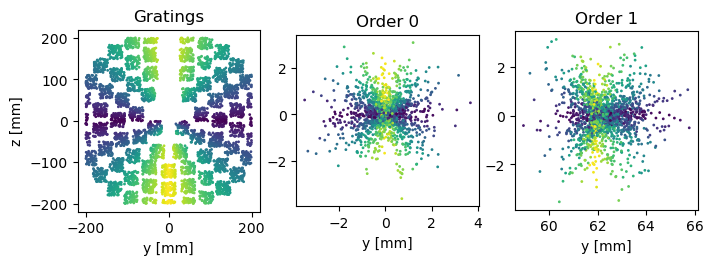

In [10]:
photons = configuration["single"]["photons05"][1]
ind0 = photons["order"] == 0  # & (photons["CCD_ID"] < 0)
ind1 = photons["order"] == 1

fig, axes = plt.subplots(ncols=3, figsize=(8, 3), subplot_kw={"aspect": "equal"})
ang = np.abs(np.arctan(photons["mirror_y"] / photons["mirror_x"]))
axes[0].scatter(
    photons["mirror_x"], photons["mirror_y"], c=ang, s=1
)
axes[1].scatter(
    photons["projcirc_x"][ind0], photons["projcirc_y"][ind0], c=ang[ind0], s=1
)
axes[2].scatter(
    photons["projcirc_x"][ind1], photons["projcirc_y"][ind1], c=ang[ind1], s=1
) 

axes[0].set_title("Gratings")
axes[1].set_title("Order 0")
axes[2].set_title("Order 1")
for ax in axes:
    ax.set_xlabel("y [mm]")
axes[0].set_ylabel("z [mm]")

fig.savefig("subaperture.pdf", bbox_inches='tight')

In [11]:
def prepare_3dview(conf):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        out = plot_object(conf["instrument"])

    out = plot_rays(conf["photons"][0], scalar=conf["photons"][1]["order"], scene=out,
                    normalize_kwargs={'vmin': -1, 'vmax': 5})

    conf["rowland_1"].display["coo1"] = np.linspace(-0, 2 * np.pi, 400)
    conf["rowland_1"].display["coo2"] = np.linspace(0, 0.2, 20)
    out = plot_object(conf["rowland_1"], scene=out)
    return out


def append_viewpoints(out, prefix=""):
    """Must be called just before display as elements added after the
    viewpoints seem not be obe displayed."""

    out.children.append(
        x3d.Viewpoint(
            description=f"{prefix}Overview ", 
            orientation=(0.5, 0.3, 0.3, -0.3), viewAll=True
        )
    )
    out.children.append(
        x3d.Viewpoint(
            description=f"{prefix}Camera",
            position=(400, 0, 200),
            orientation=(
                0,
                1,
                0,
                0.9,
            ),  # Format is (x, y, z, rot) for a rotation of rot in radian
            # around the vector (x, y, z).
        )
    )
    return out

In [12]:
out = prepare_3dview(configuration["single"])
out = append_viewpoints(out, 'on-axis: ')
out

In [13]:

out = prepare_3dview(configuration["single_tilted"])
out = append_viewpoints(out, "tilted: ")
out

In [14]:
conf = configuration["double_tilted"]

out = prepare_3dview(conf)


# display = deepcopy(conf["rowland_1"].display)
# display["color"] = (1.0, 1.0, 0.3)
# out = plot_object(conf["rowland_1m"], display=display, scene=out)

#conf["rowland_1"].display["coo1"] = np.linspace(-0, 2 * np.pi, 400)
#conf["rowland_1"].display["coo2"] = np.linspace(0, 0.1, 20)
#conf["rowland_1"].display["color"] = (1, 0, 0)
#out = plot_object(conf["rowland_1"], scene=out)

#conf["rowland_1m"].display["coo1"] = np.linspace(-0, 2 * np.pi, 400)
#conf["rowland_1m"].display["coo2"] = np.linspace(-0.1, 0., 20)
#out = plot_object(conf["rowland_1m"], scene=out)

out = append_viewpoints(out, "tilted, double: ")
out

In [15]:
conf = configuration["double_tilted_offset"]

out = prepare_3dview(conf)

#display = deepcopy(conf["rowland_1"].display)
#display["color"] = (1.0, 1.0, 0.3)
#out = plot_object(conf["rowland_1m"], display=display, scene=out)
out = append_viewpoints(out, "tilted, double, offset: ")
out

[0. 0.]
[-100.    0.]
[-100.   -5.]
[100.   5.]
[-102.5  -12. ]
[97.5 -4. ]
[-97.5   4. ]
[102.5  12. ]


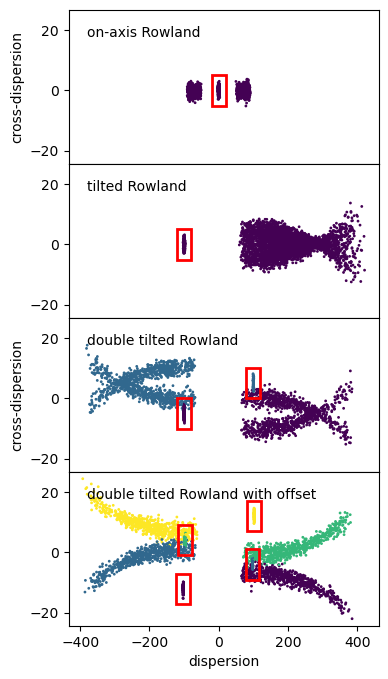

In [16]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True, figsize=(4, 8))
for conf, ax in zip(configuration.values(), axes.flatten()):
    photons = conf["photons"][1]
    ax.scatter(
        photons["projcirc_x"],
        photons["projcirc_y"],
        c=photons["xou"],
        s=1,
        vmin=0,
        vmax=3,
    )
    ax.text(-380, 18, conf["title"])
    for optax in conf["pos_opt_ax"].values():
        print(optax[1:3])
        ax.add_patch(mpatches.Rectangle(optax[1:3] - [20, 5], 40, 10, ec="r", fill=False, lw=2))
axes[0].set_ylabel("cross-dispersion")
axes[2].set_ylabel("cross-dispersion")
axes[-1].set_xlabel("dispersion")
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig("ondetector.pdf", bbox_inches="tight")

In [17]:
conf

{'title': 'double tilted Rowland with offset',
 'd_channel': 200.0,
 'offsets': {'1': [0, -2.5, -12],
  '1m': [0, -2.5, -4],
  '2': [0, 2.5, 4],
  '2m': [0, 2.5, 12]},
 'gas_phi': {'1': ([-0.6283185307179586, 0.6283185307179586],),
  '1m': ([-0.6283185307179586, 0.6283185307179586],),
  '2': ([2.5132741228718345, 3.7699111843077517],),
  '2m': ([2.5132741228718345, 3.7699111843077517],)},
 'gas_elem_class': marxs.optics.grating.CATGrating,
 'order_selector': <marxs.optics.grating.OrderSelector at 0x146e1beb0>,
 'blaze_angle': {'1': -0.4363323129985824,
  '1m': 0.4363323129985824,
  '2': -0.4363323129985824,
  '2m': 0.4363323129985824},
 'd_BF': 200.0,
 'd': 100.0,
 'f': 1000.0,
 'rowland_central': <marxs.design.rowland.RowlandTorus at 0x10702abc0>,
 'rowland_central_m': <marxs.design.rowland.RowlandTorus at 0x146dcb700>,
 'pos_det_rowland': array([   0., -100.,    0.,    1.]),
 'shift_det_rowland': array([[   1.,    0.,    0.,    0.],
        [   0.,    1.,    0., -100.],
        [   0

In [18]:
from marxs.math.utils import h2e


def format_rowland_pos4d(rowland, shift=np.eye(4)):
    """Format coordinates for one Rowland torus for printing.

    Parameters
    ----------
    rowland : marxs.design.rowland.RowlandTorus
        Roland torus in Arcus with a ``pos4d`` matrix in global coordinates.

    shift : np.array or shape (4,4)
        transformation matrix to transform the global coordinate system to the system used for output.
    """
    out = {}
    pos4d = np.dot(shift, rowland.pos4d)
    out["pos4d"] = pos4d
    out["ex"] = h2e(np.dot(pos4d, [1, 0, 0, 0]))
    out["ey"] = h2e(np.dot(pos4d, [0, 1, 0, 0]))
    out["ez"] = h2e(np.dot(pos4d, [0, 0, 1, 0]))
    out["center"] = h2e(pos4d[:, 3])
    return out

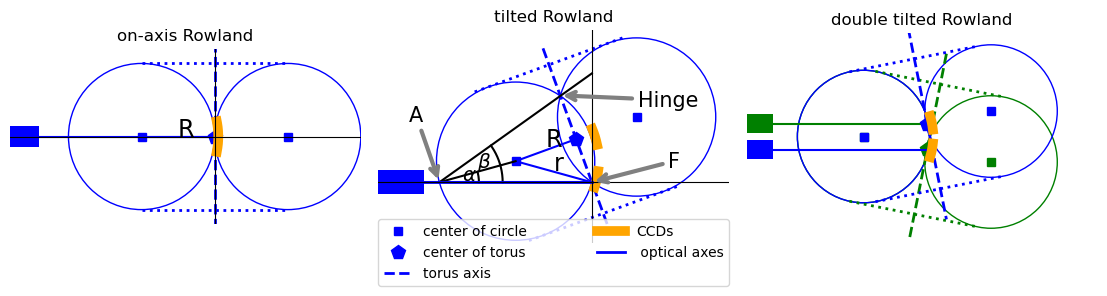

In [19]:
from matplotlib.patches import Circle, Rectangle
from matplotlib import pyplot as plt
import mpl_toolkits.axisartist as AA

conf = configuration["double_tilted"]
rowlands = [conf["rowland_1"], conf["rowland_1m"]]


conf = {
    "d_channel": 0.2,
    "offsets": {"1": [0, 0, 0], "1m": [0, 0, 0]},
}
rowlands = rowland.double_rowland_from_channel_distance(conf["d_channel"], 0.5, 1.0)
conf.update(rowlands)
rowland.add_offset_double_rowland_channels(conf, conf["offsets"])
rowlands = [conf["rowland_1"], conf["rowland_1m"]]

fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(right=0.85)
ax0 = AA.Subplot(fig, 1, 3, 1, aspect="equal")
fig.add_subplot(ax0)
ax1 = AA.Subplot(fig, 1, 3, 3, aspect="equal")
fig.add_subplot(ax1)
ax2 = AA.Subplot(fig, 1, 3, 2, aspect="equal")
fig.add_subplot(ax2)


def ax_middleaxes(ax):
    # make some axis invisible
    ax.axis["bottom", "top", "right", "left"].set_visible(False)

    # make an new axis along the first axis axis (x-axis) which pass
    # throught y=0.
    ax.axis["y=0"] = ax.new_floating_axis(nth_coord=0, value=0, axis_direction="bottom")
    ax.axis["y=0"].toggle(all=True)
    # ax.axis["y=0"].label.set_text("y = 0")
    ax.axis["z=0"] = ax.new_floating_axis(nth_coord=1, value=0, axis_direction="left")
    ax.axis["z=0"].toggle(all=True)
    for s in ["y=0", "z=0"]:
        ax.axis[s].major_ticks.set_visible(False)
        ax.axis[s].major_ticklabels.set_visible(False)


def plot_rowland(ax, rowl, rowland, color="b", more_label="", **kwargs):
    """kwargs can have additional parameters for more_label. Read the code to see which."""
    r = rowland.r
    R = rowland.R
    circlecenters = np.stack(
        [rowl["center"] + rowl["ex"] * R, rowl["center"] - rowl["ex"] * R]
    )
    # plot cirles
    ax.add_patch(Circle(circlecenters[0, [0, 1]], radius=r, fc="none", ec=color))
    ax.add_patch(Circle(circlecenters[1, [0, 1]], radius=r, fc="none", ec=color))

    # connect circles to make impression of a torus
    t = np.stack(
        [
            np.vstack(
                [
                    rowl["center"] + (rowl["ex"] + rowl["ey"]) * r,
                    rowl["center"] + (-rowl["ex"] + rowl["ey"]) * r,
                ]
            ),
            np.vstack(
                [
                    rowl["center"] + (rowl["ex"] - rowl["ey"]) * r,
                    rowl["center"] + (-rowl["ex"] - rowl["ey"]) * r,
                ]
            ),
        ],
        axis=1,
    )
    ax.plot(t[:, :, 0], t[:, :, 1], ls=":", c=color, lw=2)

    # mark circle centers
    ax.plot(
        circlecenters[:, 0],
        circlecenters[:, 1],
        marker="s",
        ls="none",
        c=color,
        label="center of circle",
    )

    # Rowland center and axis
    ax.plot(
        rowl["center"][0],
        rowl["center"][1],
        marker="p",
        c=color,
        ms=10,
        ls="none",
        label="center of torus",
    )
    ax.plot(
        [
            rowl["center"][0] + 1.5 * R * rowl["ey"][0],
            rowl["center"][0] - 1.5 * R * rowl["ey"][0],
        ],
        [
            rowl["center"][1] + 1.5 * R * rowl["ey"][1],
            rowl["center"][1] - 1.5 * R * rowl["ey"][1],
        ],
        linestyle="--",
        c=color,
        lw=2,
        label="torus axis",
    )

    # optical axis
    if "o" in more_label:
        ax.plot([kwargs["f"], 0], [kwargs["ypos"]] * 2, color=color)

    # SPOs (mirror)
    if "m" in more_label:
        width = 0.1 * r * kwargs.get("mirrorzoom", 1)
        height = 0.05 * r * kwargs.get("mirrorzoom", 1)
        ax.add_patch(
            Rectangle(
                (kwargs["f"], kwargs["ypos"] - 0.5 * height), width, height, fc=color
            )
        )

    # line and label for R
    if "R" in more_label:
        ax.plot(
            [circlecenters[0, 0], rowl["center"][0]],
            [circlecenters[0, 1], rowl["center"][1]],
            color=color,
        )
        ax.text(
            np.mean([circlecenters[0, 0], rowl["center"][0]]),
            1.1 * np.mean([circlecenters[0, 1], rowl["center"][1]]),
            "R",
            fontsize="xx-large",
        )

    # The following have a few hardcoded numbers in them that make sense only for the sketch.
    # Those can be generalized, but it just does not seem worth it right now.
    # I have however, used general expressions where it did not require any thinking already
    # so it should not be too hard to replace the remaining numbers if needed.

    # line and label for r
    if "r" in more_label:
        ax.plot([circlecenters[0, 0], 0], [circlecenters[0, 1], 0], color=color)
        ax.text(
            np.mean([circlecenters[0, 0], 0]),
            1.1 * np.mean([circlecenters[0, 1], 0]),
            "r",
            fontsize="xx-large",
        )

    # line and label for alpha
    if "a" in more_label:
        ax.plot([circlecenters[0, 0], 1], [circlecenters[0, 1], 0], color="k")
        temp = np.arange(0, kwargs["alpha"], 0.001)
        x = circlecenters[0, 0] * 2 - 0.5 * r * np.cos(temp)
        y = 0.5 * r * np.sin(temp)
        ax.plot(x, y, "k")
        ax.text(
            1 - 0.3 * circlecenters[0, 0],
            0.2 * np.mean([circlecenters[0, 1], 0]),
            r"$\alpha$",
            fontsize="x-large",
        )

    # line and label for beta
    if "b" in more_label:
        ax.plot([0, 1], [np.tan(kwargs["beta"]), 0], color="k")
        temp = np.arange(0, kwargs["beta"], 0.001)
        x = circlecenters[0, 0] * 2 - 0.8 * r * np.cos(temp)
        y = 0.8 * r * np.sin(temp)
        ax.plot(x, y, "k")
        ax.text(
            1 - 0.5 * circlecenters[0, 0],
            0.7 * circlecenters[0, 1],
            r"$\beta$",
            fontsize="x-large",
        )

    # line and label for CCDs
    if "d" in more_label:
        for l, angles in zip(["CCDs", "__no_legend__"], kwargs["ccdphi"]):
            temp = np.arange(angles[0], angles[1], 0.001)
            x = circlecenters[0, 0] - 1.05 * r * np.cos(temp)
            y = circlecenters[0, 1] + 1.05 * r * np.sin(temp)
            ax.plot(x, y, "orange", lw=7, label=l)


from marxs.design.rowland import design_tilted_torus, RowlandTorus

ax_middleaxes(ax0)
rowland_sketch = RowlandTorus(R=0.5, r=0.5)

plot_rowland(
    ax0,
    format_rowland_pos4d(rowland_sketch),
    rowland_sketch,
    more_label="Rmdo",
    f=1.2,
    ypos=0,
    mirrorzoom=6,
    ccdphi=[[-0.2, 0.2]],
)

ax0.set_xlim([1.4, -1])
ax0.set_ylim([-0.6, 0.6])
ax0.set_title(configuration["single"]["title"])


plot_rowland(
    ax1,
    format_rowland_pos4d(rowlands[1]),
    rowlands[1],
    "g",
    more_label="mo",
    f=1.2,
    ypos=conf["d"],
    mirrorzoom=6,
)
plot_rowland(
    ax1,
    format_rowland_pos4d(rowlands[0]),
    rowlands[0],
    more_label="mod",
    f=1.2,
    ypos=-conf["d"],
    alpha=0.3,
    beta=0.6,
    mirrorzoom=6,
    ccdphi=[[-0.3, -0.1], [0.1, 0.3]],
)

ax1.set_xlim([1.400, -1.300])
ax1.set_ylim([-0.800, 0.800])
ax1.set_title(configuration["double_tilted"]["title"])
ax1.axis["bottom", "top", "right", "left"].set_visible(False)


from marxs.design.rowland import design_tilted_torus, RowlandTorus

ax_middleaxes(ax2)
R, r, pos4d = design_tilted_torus(1.0, 0.27, 0.62)
rowland_sketch = RowlandTorus(R=R, r=r, pos4d=pos4d)

plot_rowland(
    ax2,
    format_rowland_pos4d(rowland_sketch),
    rowland_sketch,
    more_label="Rrabmdo",
    alpha=0.27,
    beta=0.62,
    f=1.1,
    ypos=0,
    mirrorzoom=6,
    ccdphi=[[0.2, 0.4], [-0.32, -0.12]],
)
ax2.plot([1.2, 0], [0, 0], "b", lw=2, label=" optical axes")
# ax2.plot([1.2, 0], [2 * r * np.sin(0.3)] * 2, "g", label="second opt. ax")
ax2.set_xlim([1.4, -0.9])
ax2.set_ylim([-0.4, 1.0])
ax2.set_title(configuration["single_tilted"]["title"])
out = ax2.legend(
    numpoints=1,
    loc="lower left",
    bbox_to_anchor=(0.0, -0.2, 1.0, 0.102),
    ncols=2,
    mode="expand",
    borderaxespad=0.0,
)

ax2.annotate(
    "F",
    xy=(0, 0),
    xycoords="data",
    xytext=(-0.5, 0.1),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=3, ec="0.5"),
    fontsize=15,
)
ax2.annotate(
    "Hinge",
    xy=(0.21, 0.57),
    xycoords="data",
    xytext=(-0.3, 0.5),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=3, ec="0.5"),
    fontsize=15,
)

ax2.annotate(
    "A",
    xy=(1, 0.),
    xycoords="data",
    xytext=(1.2, 0.4),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=3, ec="0.5"),
    fontsize=15,
)

fig.subplots_adjust(wspace=0.05)

fig.savefig("sketch.pdf", bbox_inches="tight")

### Print out some number for Arcus that I use in the text

In [20]:
from marxs.missions.arcus.arcus import defaultconf as arcusconf

In [21]:
arcusconf['d_BF'], arcusconf['f']

(750.0, 11876.430761)

In [22]:
arcusconf['rowland_central'].r, arcusconf['rowland_central'].R

(5950.044277583718, 5915.51307)

In [23]:
alpha = np.arccos(arcusconf["f"] / 2 / arcusconf['rowland_central'].r)
np.rad2deg(alpha)

3.613446539107349